## Import libraries

In [1]:
# Math libraries
import pandas as pd
import numpy as np
import math
import collections

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Model evaluation
from sklearn.model_selection import RandomizedSearchCV  # parameter tuning
from sklearn.metrics import roc_auc_score, roc_curve  
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import eli5  # for permutation importance
from eli5.sklearn import PermutationImportance
import shap   # for shap values
from pdpbox import pdp, info_plots

## Visualization styles

In [2]:
plt.style.use('fivethirtyeight')

## Import Dataset

In [700]:
dataset_train = pd.read_csv('train.csv')
dataset_test = pd.read_csv('test.csv')

#### We need to merge both train and test data, we will create a new column named train with values equal 1 for train data and 0 for test data

In [701]:
dataset_train['Train'] = 1
dataset_test['Train'] = 0

In [702]:
# Merge train and test datasets into one dataset
dataset = pd.concat([dataset_train, dataset_test], ignore_index=True)

In [703]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [704]:
# Shape of the data
dataset.shape

(1309, 13)

### We are going to rename some features to get a better understanding of the data

In [705]:
col_names = {'Pclass': 'Ticket class',
             'SibSp': 'Siblings_spouses',
             'Parch': 'Parents_children',
             'Embarked': 'Embarkation port'}

dataset.rename(columns=col_names, inplace=True)


In [706]:
dataset.head()

,PassengerId,Survived,Ticket class,Name,Sex,Age,Siblings_spouses,Parents_children,Ticket,Fare,Cabin,Embarkation port,Train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


## Data exploration

In [707]:
# Explore columns types
dataset.dtypes

PassengerId           int64
Survived            float64
Ticket class          int64
Name                 object
Sex                  object
Age                 float64
Siblings_spouses      int64
Parents_children      int64
Ticket               object
Fare                float64
Cabin                object
Embarkation port     object
Train                 int64
dtype: object

#### We notice that there is five categorical features need to be encoded

In [708]:
# General statistics of the data
dataset.describe()

,PassengerId,Survived,Ticket class,Age,Siblings_spouses,Parents_children,Fare,Train
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


#### We notice that the maximum value in Fare, Age and Siblings columns are very high compared to the mean which can be an indicator of an outlier, also the minimum value in the Fare column is 0 which is awkward, and the minimum value in the age column is 0.17 which may be babies with their mums

In [709]:
# Check for duplicated rows
dataset[dataset.duplicated()]

,PassengerId,Survived,Ticket class,Name,Sex,Age,Siblings_spouses,Parents_children,Ticket,Fare,Cabin,Embarkation port,Train


#### There is no duplicated rows

In [710]:
# Check for null values
nulls = dataset.drop(['Survived', 'Train'], axis=1).isnull().sum()
nulls

PassengerId            0
Ticket class           0
Name                   0
Sex                    0
Age                  263
Siblings_spouses       0
Parents_children       0
Ticket                 0
Fare                   1
Cabin               1014
Embarkation port       2
dtype: int64

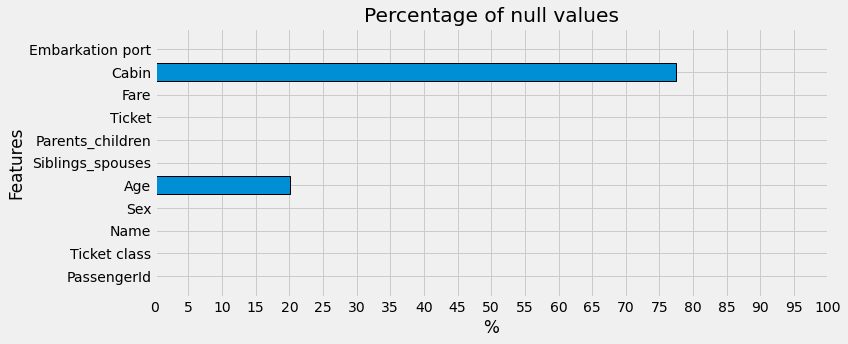

In [711]:
# Visualize percentage of null values
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the percentage of the null value in every column
ax.barh(nulls.index, (nulls/len(dataset))*100, edgecolor='black', linewidth=1)

# Change x-axis values
ax.set_xticks([i for i in range(0, 101, 5)])
plt.xlabel('%')
plt.ylabel('Features')
plt.title('Percentage of null values')
plt.tight_layout()

#### We have multiple null values in Four columns
1. In our first feature (Embarkation port) we have only 2 null values so i will drop their corresponding rows if they belongs to train_data if not replace null value with median value
2. We will do the same for null value in Fare Column
3. In the next feature (Cabin) more than 75% of the data are missing so i think it would be better if we just dropped this column
4. There is like 20% missing data in Age feature and we need to find a way to handle them

In [712]:
# Embarkation port feature
# Check if the values in train data or test data
dataset[dataset['Embarkation port'].isnull()]

,PassengerId,Survived,Ticket class,Name,Sex,Age,Siblings_spouses,Parents_children,Ticket,Fare,Cabin,Embarkation port,Train
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


#### The values are in the train data so we will drop them

In [713]:
dataset = dataset[dataset['Embarkation port'].notna()]

In [714]:
# Drop Cabin column
dataset.drop('Cabin', axis=1, inplace=True)

In [715]:
# Fare feature
dataset[dataset['Fare'].isnull()]

,PassengerId,Survived,Ticket class,Name,Sex,Age,Siblings_spouses,Parents_children,Ticket,Fare,Embarkation port,Train
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0


#### The null value in the test data

In [716]:
# Replace null value in Fare feature with the median
dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

#### In age feature we can check if the sample has a spouse and childeren their age will probably be in the range on 30-40 and if they don't their age will probably be in the range of 18-30, however, spouse and childeren features can be siblings and parents instead so we can't rely on this method, so i think the best way is to just replace the null values with the median value

In [717]:
# Replace null values in age column with the medina
dataset['Age'].fillna(dataset['Age'].median(), inplace=True)

In [718]:
# Recheck null values
dataset.isnull().sum()

PassengerId           0
Survived            418
Ticket class          0
Name                  0
Sex                   0
Age                   0
Siblings_spouses      0
Parents_children      0
Ticket                0
Fare                  0
Embarkation port      0
Train                 0
dtype: int64

## Categorical features encoding

### There are 4 categorical features in our dataset
1. Name feature: Get the most common words from it
2. Sex feature: we will replace male values with ones and females with zeros
3. Ticket feature: this feature needs further searching
4. Embarkation port feature: we will use OneHotEncoding 

#### Name feature

In [719]:
# Check the most common words in Names column
names_list = []
dataset['Name'].apply(lambda x: names_list.append(x))
names_list = ' '.join(names_list).split()
common_names = dict(collections.Counter(names_list).most_common(6))  # Take the top 6 common names
common_names = set(common_names)

# Replace values in names column with one of the most common words if exist
dataset['Name'] = dataset['Name'].apply(lambda x: set(
    x.split())).apply(lambda x: list(x.intersection(common_names)))
dataset['Name'] = dataset['Name'].apply(lambda x: x[0] if x else 'Other')



#### Then i will use get dummies encoding to encode this feature but after the visualization

#### Sex feature 

In [720]:
# Encode Sex column
dataset['Sex'].replace({'male':1, 'female':0}, inplace=True)

#### Embarkation port

In [721]:
# Encode Embarkation port column
dataset['Embarkation port'].value_counts()

S    914
C    270
Q    123
Name: Embarkation port, dtype: int64

#### S: Southampton, A port in England
#### C: Cherbourg, A port in a town in France
#### Q: Queenstown, A port in South Ireland
#### We notice that there is no priority in any of this ports, so we will use get dummies encoder

In [722]:
dataset = pd.get_dummies(dataset, columns=['Embarkation port'], drop_first=True)  # drop first column to avoid Multicollinearity

#### Ticket feature

In [723]:
dataset['Ticket'].value_counts()

CA. 2343    11
1601         8
CA 2144      8
347077       7
347082       7
            ..
2623         1
113043       1
350417       1
237671       1
334914       1
Name: Ticket, Length: 928, dtype: int64

#### Ticket column has more than 900 unique values some of them have prefix which may be related to ticket class and others don't, so i will drop this column

In [724]:
dataset.drop(columns=['Ticket'], axis=1, inplace=True)

### Now we need to return our data into train and test data to do further visual analyzation


In [725]:
train_data = dataset[dataset['Train'] == 1]
test_data = dataset[dataset['Train'] == 0]

# Drop Train column in both datasets
train_data.drop(columns=['Train'], axis=1, inplace=True)
test_data.drop(columns=['Train'], axis=1, inplace=True)

In [726]:
dataset = pd.get_dummies(dataset, columns=['Name'], drop_first=True)  # drop first column to avoid Multicollinearity


## Exploratory data analysis (Visualizations)

In [727]:
# Create a function to visualize surviaval relation with every feature
def bar_plot(dataset, feature, y_label, x_label, title_,
                 figsize_=(10, 5), plot_percentage=False,
                 width_=0.2, loc_='upper right', xticks_labels=[],
                 xticks_=[]):
    """plot bar plots

        Args:
            dataset (pandas dataframe): The dataset containing features and prediction target
            feature (str): A feature to be explored
            y_label (str) : Label of Y-axis
            x_label (str) : Label of X-axis
            title (str) : Title of the plot
            figsize (tuple) : Size of the figure
            plot_percentage(bool) : Whether to plot number of survived samples or the percentage
            width_ (float) : Width of bars 
            loc (str) : Legend location
            xticks_labels (list) : Change labels xticks
            xticks (list) : Change xticks
        
    """
    # Create a dataframe with number survived and dead people in every age
    feature = dataset.groupby(
        [feature, 'Survived'])['Survived'].count().unstack(level=1, fill_value=0)

    # Create new dataframe with percentage of survival
    percentage = feature.copy()
    percentage[1] = (percentage[1] / (percentage[0]+percentage[1]))*100
    percentage[0] = 100 - percentage[1]
    
    if plot_percentage:
        feature = percentage
        
    x = feature.index
    if type(x[0]) == str:
        x = xticks_
    plt.figure(figsize=figsize_)  # set figure size
    plt.bar([i+width_ for i in x], feature[1], color='#61d972', width=width_)
    plt.bar(x, feature[0], color='#363c97', width=width_)

    # Plot modification
    if xticks_labels:
        plt.xticks(xticks_, labels=xticks_labels)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title_)
    plt.legend(["Survived", "Didn't survive"], loc=loc_, 
               fancybox=True, handlelength=0.8, handleheight=0.4,
               fontsize='small')
    plt.tight_layout()


### Age Feature

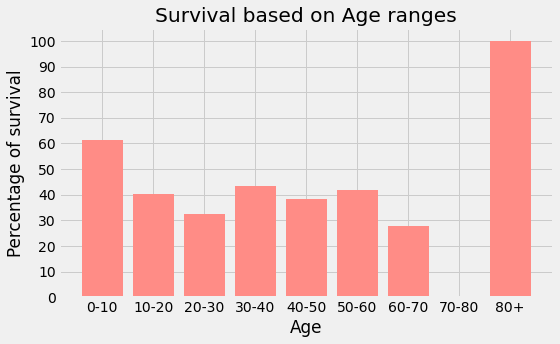

In [728]:
# Create a dataframe with number survived and dead people in every age
feature = train_data.groupby(
    ['Age', 'Survived'])['Survived'].count().unstack(level=1, fill_value=0)

# replace ages with range of ages
age_range = ['0-10', '10-20', '20-30', '30-40', '40-50', 
             '50-60', '60-70', '70-80', '80+', '80+']
feature.reset_index(inplace=True)
feature['Age'] = feature['Age'].apply(lambda x: math.floor(x/10)*10)  # round ages to lowest 10
age = feature['Age'].unique().tolist()  # get a list of ages in dataset
feature['Age'] = feature['Age'].map(dict(zip(age, age_range)))  # replace original ages with age ranges
feature = feature.groupby(['Age'])[1, 0].sum()
feature['Sum'] = feature[1] + feature[0]
feature['Percentage'] = (feature[1] / feature['Sum'])*100

# Plot percentage of survival based on age region
plt.figure(figsize=(8, 5))
plt.bar(feature.index, feature['Percentage'], color='#ff8c86')

# Plot modification
plt.yticks([i for i in range(0, 101, 10)])
plt.ylabel('Percentage of survival')
plt.xlabel('Age')
plt.title('Survival based on Age ranges')
plt.tight_layout()

In [729]:
feature

Survived,1,0,Sum,Percentage
Age,,,,
0-10,38,24,62,61.290323
10-20,41,61,102,40.196078
20-30,129,268,397,32.493703
30-40,72,94,166,43.373494
40-50,34,55,89,38.202247
50-60,20,28,48,41.666667
60-70,5,13,18,27.777778
70-80,0,6,6,0.000000
80+,1,0,1,100.000000


#### We notice that elders with more than 80 years have a 100% chance of surviving, however as we can see we only have one sample with age more than 80 so this is likely to be an outlier(I will drop it later), and the highest value of surviving is for kids in the range from 0 to 10.

### Ticket class feature

In [730]:
train_data['Ticket class'].value_counts()

3    491
1    214
2    184
Name: Ticket class, dtype: int64

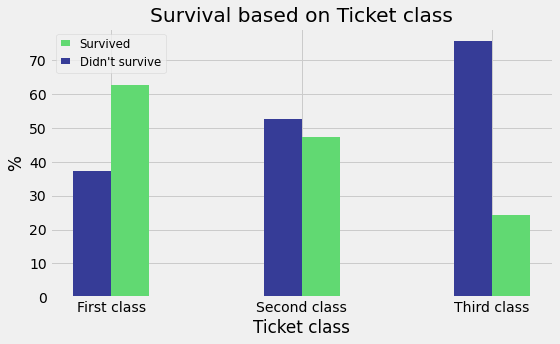

In [731]:
bar_plot(train_data, 'Ticket class', y_label='%', 
         x_label='Ticket class', title_='Survival based on Ticket class',
         figsize_=(8, 5), loc_='upper left', plot_percentage=True, xticks_=[1.1, 2.1, 3.1],
         xticks_labels=['First class', 'Second class', 'Third class'])

#### From the plot above we can see that most of the people who survived the titanic (more than 60%) were from the first class, and more than 70% of people of the third class didn't survive 

### Name Feature

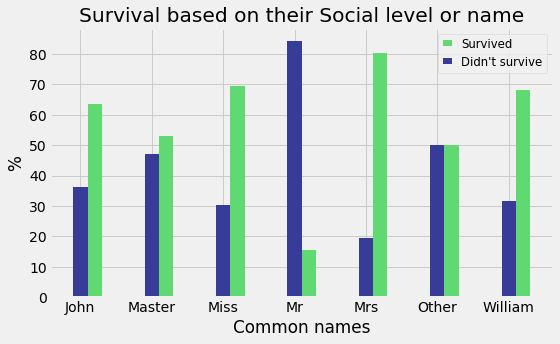

In [732]:
bar_plot(train_data, 'Name', y_label='%', 
         x_label='Common names', title_='Survival based on their Social level or name',
         figsize_=(8, 5), loc_='upper right', plot_percentage=True, xticks_=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1],
     xticks_labels=['John', 'Master', 'Miss', 'Mr', 'Mrs', 'Other', 'William'])

#### The previous plot shows that women in most cases had a higher percentage of survival (Miss, Mrs), also master and people named William had a higher percentage of survival

### Sex feature

In [733]:
train_data['Sex'].value_counts()

1    577
0    312
Name: Sex, dtype: int64

#### We notice that the titanic had more males than females in general (1 for Male, 0 for Female)

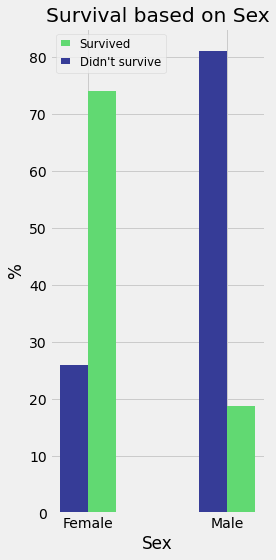

In [734]:
# Plot percentage of survival 
bar_plot(train_data, 'Sex', y_label='%', 
         x_label='Sex', title_='Survival based on Sex',
         figsize_=(4, 8), loc_='upper left', xticks_=[0.1, 1.1],
         xticks_labels=['Female', 'Male'], plot_percentage=True)

#### More than 70% of females did survive, and more than 80% of males did not survive

### Relation between age, sex and survival

In [735]:
features = train_data[['Age', 'Sex', 'Survived']]
features['Age'] = features['Age'].apply(lambda x: math.floor(x/10)*10)
features = features[features['Age'] < 80]  # remove the outlier in age 80
features['Age'] = features['Age'].map(dict(zip(age, age_range)))  # replace original ages with age ranges
features['Sex'] = features['Sex'].map({0: 'Female', 1:'Male'})
features = features.groupby(['Age', 'Sex', 'Survived'])['Survived'].count().unstack().fillna(0)
features = features.unstack().fillna(0)

In [736]:
features

Survived    0.0           1.0      
Sex      Female   Male Female  Male
Age                                
0-10       11.0   13.0   19.0  19.0
10-20      11.0   50.0   34.0   7.0
20-30      37.0  231.0   88.0  41.0
30-40      10.0   84.0   49.0  23.0
40-50      10.0   45.0   22.0  12.0
50-60       2.0   26.0   16.0   4.0
60-70       0.0   13.0    3.0   2.0
70-80       0.0    6.0    0.0   0.0

Text(0.5, 1.0, 'Survival percentage relative to the age')

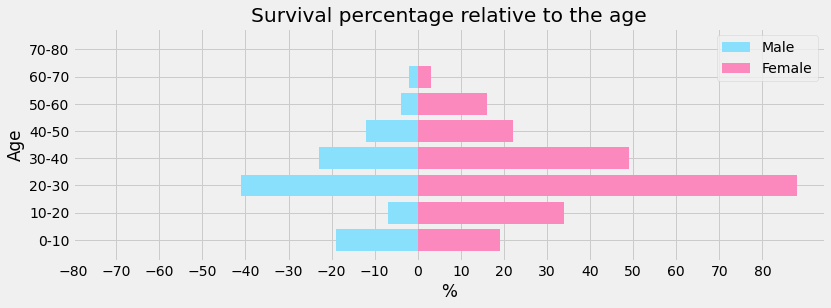

In [737]:
ticks = [-i for i in range(80, 0, -10)] + [i for i in range(0, 81, 10)]
plt.figure(figsize=(12, 4))
plt.barh(features.index, -features[1]['Male'], color='#89e0fc')
plt.barh(features.index, features[1]['Female'], color='#fc89bd')
plt.legend(['Male', 'Female'])
plt.xticks(ticks)
plt.xlabel('%')
plt.ylabel('Age')
plt.title('Survival percentage relative to the age')

#### Females have a higher percentage of survival in almost all age ranges but mostly in the 20-30 range, kids in the 0-10 range have an equal percentage of survival regardless the sex.

### Siblings spouses feature

In [738]:
# Get unique values in the feature
train_data['Siblings_spouses'].value_counts()

0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: Siblings_spouses, dtype: int64

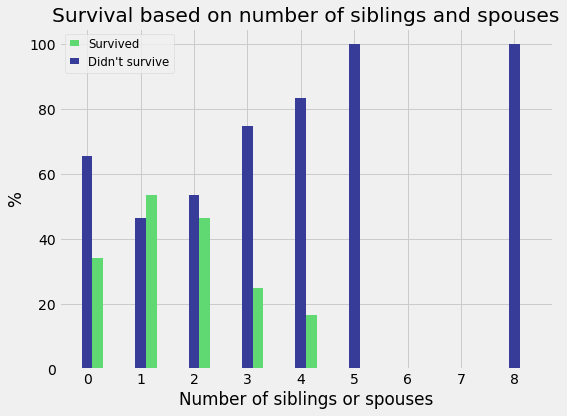

In [739]:
# Plot percentage of survival 
bar_plot(train_data, 'Siblings_spouses', y_label='%', 
         x_label='Number of siblings or spouses', title_='Survival based on number of siblings and spouses',
         figsize_=(8, 6), loc_='upper left', plot_percentage=True, xticks_=[i for i in range(9)],
         xticks_labels=[i for i in range(9)])

#### There is no really useful information from this feature

### Parents and children feature 

In [740]:
# Get unique values
train_data['Parents_children'].value_counts()

0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parents_children, dtype: int64

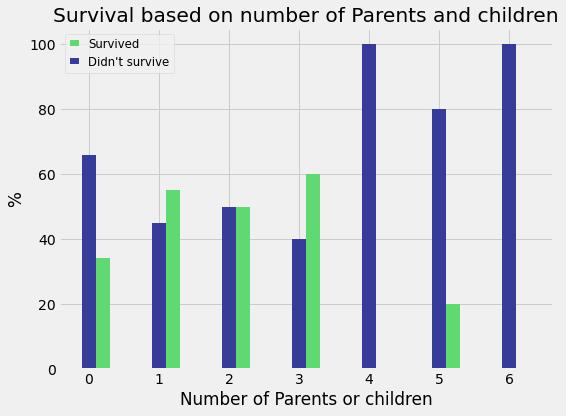

In [741]:
# Plot percentage of survival 
bar_plot(train_data, 'Parents_children', y_label='%', 
         x_label='Number of Parents or children', title_='Survival based on number of Parents and children',
         figsize_=(8, 6), loc_='upper left', plot_percentage=True)

#### Nothing really special here either

#### We may notice that in both the number of parents and children, and the number of siblings and spouses features that after a certain point the more relative you have the lower the chance of survival, and I think this is due to dataset low samples in these ranges, It makes more sense that if you have a lot of children you should get higher priority of survival.

### Embarked feature

In [742]:
dataset_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

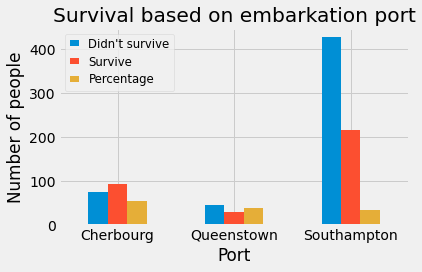

In [743]:
port = dataset_train.groupby(['Embarked', 'Survived'])['Embarked'].count().unstack(level=1)
port['percentage'] = (port[1] / (port[1] + port[0])) * 100
port.index = ['Cherbourg', 'Queenstown', 'Southampton']
port.plot(kind='bar', rot=0)

plt.ylabel('Number of people')
plt.xlabel('Port')
plt.title('Survival based on embarkation port')
plt.legend(["Didn't survive", "Survive", "Percentage"],  
           fancybox=True, handlelength=0.8, handleheight=0.4,
           fontsize='small')
plt.tight_layout()

In [744]:
port

Survived,0,1,percentage
Cherbourg,75,93,55.357143
Queenstown,47,30,38.961039
Southampton,427,217,33.695652


#### Cherbourg port had the highest percentage of suvival and next was Queenstown port, but the difference between the three percentages are not very big

### Fare feature

In [745]:
train_data['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
7.8000      1
13.8583     1
7.6292      1
15.0500     1
8.6833      1
Name: Fare, Length: 247, dtype: int64

#### Due to fare feature various unique values i will take average values for every range of fare prices, to try to get any useful insights

In [746]:
fare = train_data.copy()
fare['Fare'] = fare['Fare'].apply(lambda x: math.floor(x/10)*10)
fare = fare.groupby(['Fare', 'Survived'])['Survived'].count().unstack().fillna(0)
fare['percentage'] = (fare[1] / (fare[1] + fare[0]))*100

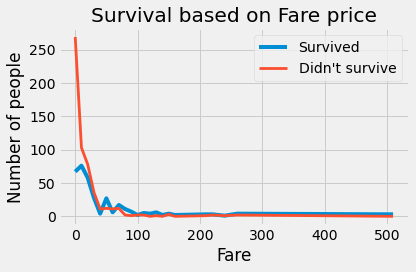

In [747]:
plt.plot(fare[1])
plt.plot(fare[0], lw=2.8)
plt.xlabel('Fare')
plt.ylabel('Number of people')
plt.title('Survival based on Fare price')
plt.legend(["Survived", "Didn't survive"])
plt.tight_layout()

#### We notice that most of the people who didn't survive paid the lowest fares, but as the fares go up the number of people who survived or not are roughly the same 

## Check for outliers

In [748]:
# Return our dataset to train and test
train = dataset[dataset['Train'] == 1]
test = dataset[dataset['Train'] == 0]

### We will use boxplots to check for outliers for features with continuous values in the whole dataset (train + test)

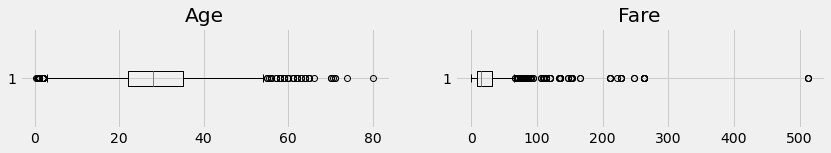

In [749]:
# Get a list of the features
cols = ['Age', 'Fare']

fig = plt.figure(figsize=(18,10))
a1 = fig.add_subplot(531)
a2 = fig.add_subplot(532)
fig.tight_layout(h_pad=2, w_pad=2)
ax = [a1, a2]
for i in range(len(cols)):
    ax[i].boxplot(train[cols[i]], vert=False)
    ax[i].title.set_text(cols[i])

    

In [750]:
# Remove extreme outliers in Fare and Age features
train = train[~(train['Age'] > 70)]
train = train[~(train['Fare'] > 200)]

#### Age feature values are normally distributed, and we can't change outliers values as they contain important information about out data, so maybe we will pick a model immune to outliers

## Check for skewness of the data

In [751]:
dataset = pd.concat([train, test], ignore_index=True)

#### In skewed data, the tail region may act as an outlier for the statistical model and outliers can have a bad effect on our model.

In [752]:
# Get a list of the features
cols = ['Age', 'Fare']

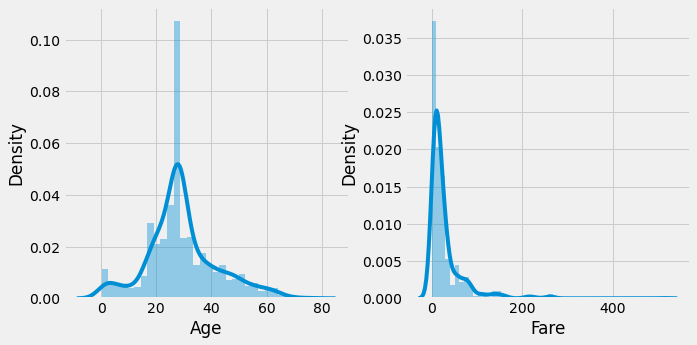

In [753]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, feature in zip(axes.flat, cols):
    sns.distplot(dataset[feature] , ax=ax)

In [754]:
# Do statistical check for normal distribution
normaltest(dataset.Age.values)

NormaltestResult(statistic=57.43888473422344, pvalue=3.367477143199914e-13)

In [755]:
normaltest(dataset.Fare.values)

NormaltestResult(statistic=1131.5987351589708, pvalue=1.889978204604694e-246)

#### This is a statistical test that tests whether a distribution is normally distributed or not. It isn't perfect, but suffice it to say: 
    * This test outputs a "p-value". The _higher_ this p-value is the _closer_ the distribution is to normal.

#### Fare features are righht skewed, so i will apply Box cox transformation

In [756]:
dataset['Fare'] += 1
bc_result = boxcox(dataset.Fare)
dataset['Fare'] = bc_result[0]

<AxesSubplot:xlabel='Fare', ylabel='Density'>

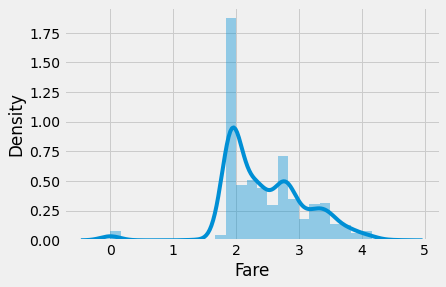

In [757]:
sns.distplot(dataset['Fare'])

In [758]:
normaltest(dataset.Fare)

NormaltestResult(statistic=46.93373860981857, pvalue=6.433808843606456e-11)

In [759]:
bc_result = boxcox(dataset.Age)
dataset['Age'] = bc_result[0]
normaltest(dataset.Age)

NormaltestResult(statistic=20.831064533693393, pvalue=2.9963449567332825e-05)

In [760]:
# Return our dataset to train and test
train = dataset[dataset['Train'] == 1]
test = dataset[dataset['Train'] == 0]

## Check for variable correlation using heat maps

In [761]:
# Set passengerid feature as index column
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)

In [762]:
# Extract survive feature from the dataset
surv = train[['Survived']]
train.drop(['Survived', 'Train'], inplace=True, axis=1)
test.drop(['Survived', 'Train'], inplace=True, axis=1)

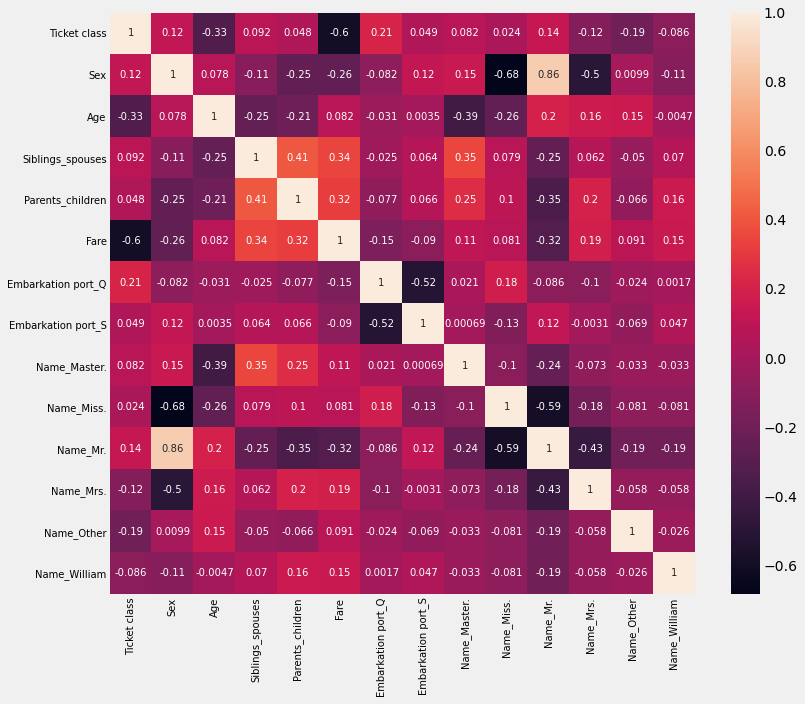

In [763]:
correlation = train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation,annot=True, annot_kws={'size':10})

# Change ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

#### Drop one of the highly correlated features (Name_Mr, Sex)

In [764]:
train.drop(['Name_Mr.'], inplace=True, axis=1)
test.drop(['Name_Mr.'], inplace=True, axis=1)

## Scaling data using standarization

In [765]:
# Initialize the Scalar
scaler = MinMaxScaler()

# Scale the data
cols = train.columns.tolist()
train[cols] = scaler.fit_transform(train[cols])
test[cols] = scaler.transform(test[cols])

#### All features values are now between zero and one

## Model selection

In [766]:
x = train
y = surv

### Perceptron algorithm

In [767]:
clf = Perceptron(shuffle=True, penalty='l2', max_iter=100000)
scores = cross_val_score(clf, x, y, cv=10).sum() / 10
scores

0.68728949478749

### Logestic regression

In [768]:
clf = LogisticRegression()
scores = cross_val_score(clf, x, y, cv=10).sum() / 10
scores

0.8148222400427694

### Naive Bayes

In [769]:
clf = GaussianNB()
scores = cross_val_score(clf, x, y, cv=10).sum() / 10
scores

0.8055733761026463

### K-nearest neighbours

In [770]:
clf = KNeighborsClassifier()
scores = cross_val_score(clf, x, y, cv=10).sum() / 10
scores

0.8045175086875167

### Support vector machine

In [771]:
clf = svm.SVC(kernel='poly')
scores = cross_val_score(clf, x, y, cv=10).sum() / 10
scores

0.8263966853782412

### Decision tree classifier

In [772]:
clf = DecisionTreeClassifier(criterion='entropy')
scores = cross_val_score(clf, x, y, cv=10).sum() / 10
scores

0.7767976476877839

### Random Forest classifier

In [773]:
clf = RandomForestClassifier(n_estimators=200, min_samples_split=5,
                             min_samples_leaf=1, max_depth=19,
                             criterion='gini')
scores = cross_val_score(clf, x, y, cv=10).sum() / 10
scores

0.8195402298850574

In [774]:
clf = xgb.XGBClassifier()
scores = cross_val_score(clf, x, y, cv=10).sum() / 10
scores

[10:49:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.8126436781609195

#### The model with the best accuracy is Random forest

## Model evaluation 

### Tuning parameters

In [775]:
def tuning_param(x, y):
    param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000],
    'criterion':['gini', 'entropy'],
    'oob_score':[True, False]
    }
    clf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(clf, param_grid, cv=5)
    rf_random.fit(x, y)
    return rf_random

In [776]:
# Split train data into validation set and training set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [777]:
clf = tuning_param(x_train, y_train)
print(clf.best_params_ ,clf.best_score_)

{'oob_score': True, 'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 90, 'criterion': 'entropy'} 0.8318425760286224


In [778]:
# Predict y on training set and test set
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

#### Confusion matrix for traininig set


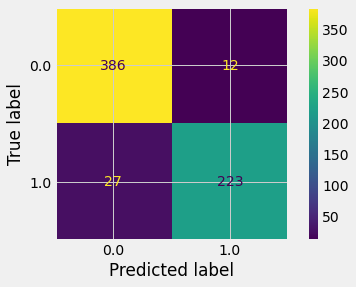

In [779]:
plot_confusion_matrix(clf, x_train, y_train)

In [780]:
clf.score(x_train, y_train)

0.9398148148148148

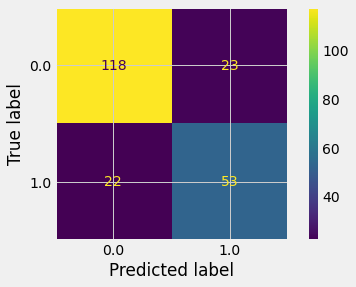

In [781]:
# Confusion matrix for training set
plot_confusion_matrix(clf, x_test, y_test)

In [782]:
clf.score(x_test, y_test)

0.7916666666666666

### ROC-AUC curve

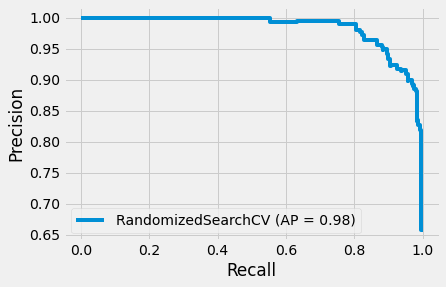

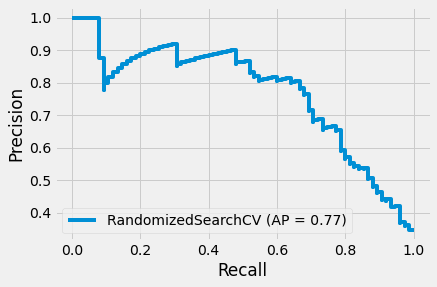

In [783]:
plot_precision_recall_curve(clf, x_train, y_train)
plot_precision_recall_curve(clf, x_test, y_test)

#### The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

### f1-score

In [784]:
f1_score(y_train, y_train_pred)

0.9195876288659794

In [785]:
f1_score(y_test, y_test_pred)

0.7019867549668874

#### f1_score for training data is high cause we have low false positives and false negatives, however, for testing data the score is lower because we have more false positives and false negatives in our test set.

### Feature importance

#### Permutation importance

In [786]:
# For training data
perm = PermutationImportance(clf).fit(x_train, y_train)
eli5.show_weights(perm, feature_names=x.columns.tolist())

Weight,Feature
0.1765 ± 0.0367,Sex
0.0901 ± 0.0095,Fare
0.0864 ± 0.0145,Age
0.0654 ± 0.0089,Ticket class
0.0318 ± 0.0097,Siblings_spouses
0.0244 ± 0.0090,Parents_children
0.0204 ± 0.0060,Embarkation port_S
0.0117 ± 0.0057,Name_Mrs.
0.0074 ± 0.0063,Name_Miss.
0.0059 ± 0.0030,Name_Master.


In [787]:
# For testing data
perm_test = PermutationImportance(clf).fit(x_test, y_test)
eli5.show_weights(perm_test, feature_names=x.columns.tolist())

Weight,Feature
0.1083 ± 0.0278,Sex
0.0407 ± 0.0295,Age
0.0361 ± 0.0258,Ticket class
0.0120 ± 0.0191,Siblings_spouses
0.0056 ± 0.0301,Fare
0.0028 ± 0.0094,Name_Master.
0 ± 0.0000,Embarkation port_Q
-0.0000 ± 0.0166,Name_Miss.
-0.0009 ± 0.0037,Name_William
-0.0009 ± 0.0108,Name_Mrs.


#### The most important 4 features is Sex, Ticket class, Fare and Age as we found in previous EDA step

### Partial dependance

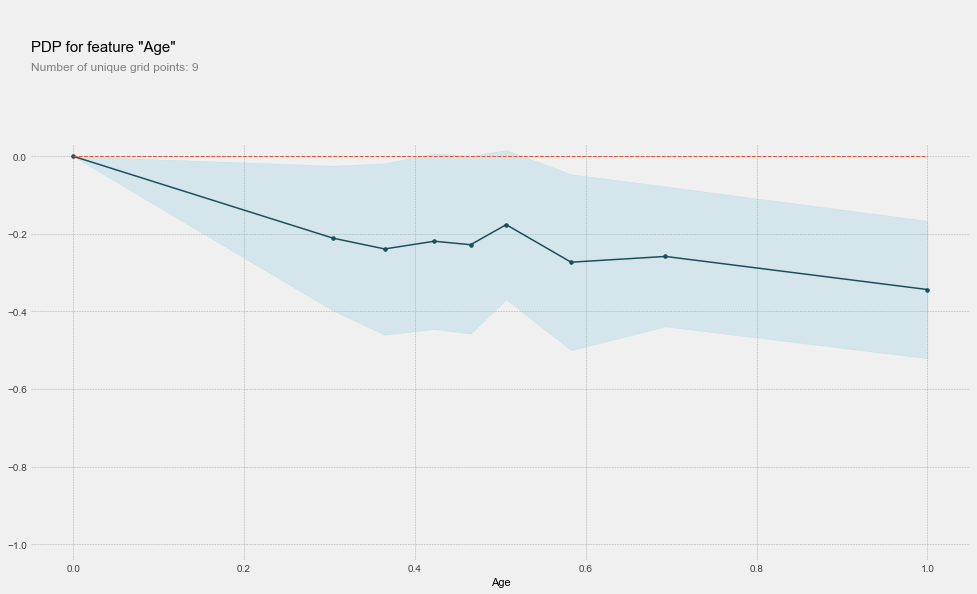

In [788]:
features = x_train.columns.to_list()
pdp_goals = pdp.pdp_isolate(model=clf, dataset=x_train,
                           model_features=features,
                           feature='Age')
pdp.pdp_plot(pdp_goals, 'Age')
plt.show()

#### The lower the age the higher the chance to surive

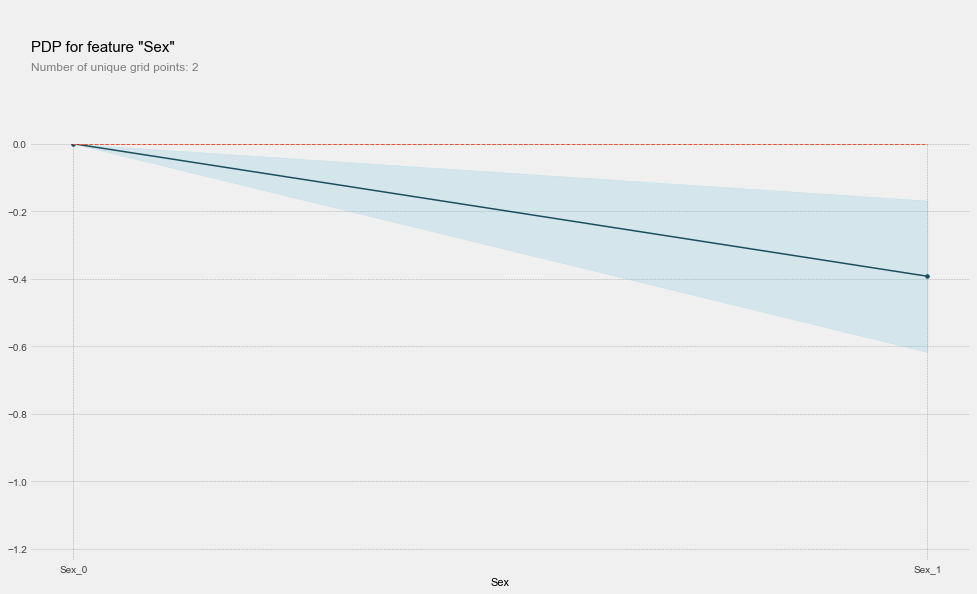

In [789]:
pdp_goals = pdp.pdp_isolate(model=clf, dataset=x_train,
                           model_features=features,
                           feature='Sex')
pdp.pdp_plot(pdp_goals, 'Sex')
plt.show()

#### Females have higher chance of surviving

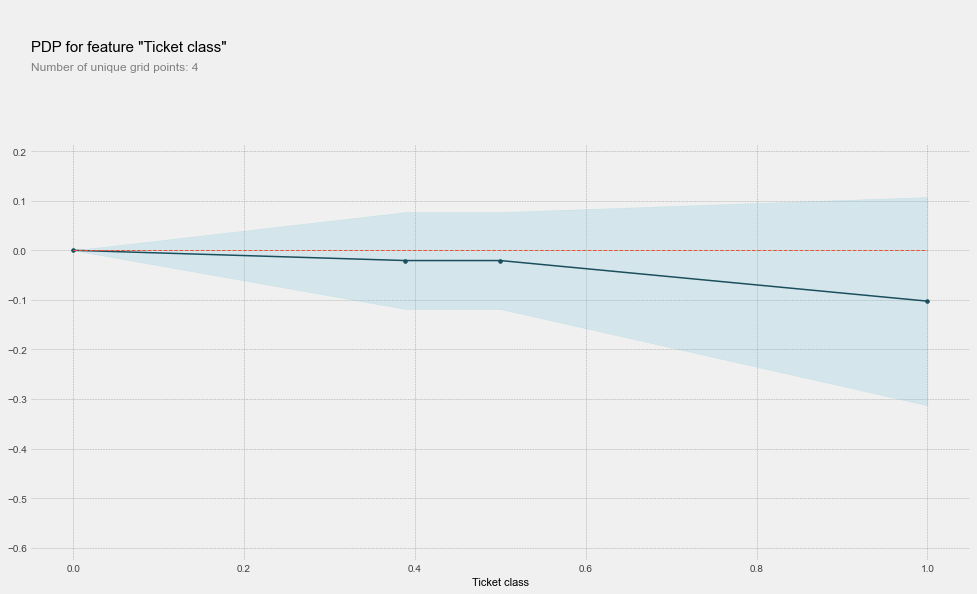

In [790]:
pdp_goals = pdp.pdp_isolate(model=clf, dataset=x_train,
                           model_features=features,
                           feature='Ticket class')
pdp.pdp_plot(pdp_goals, 'Ticket class')
plt.show()

#### Lower ticket class means first or second class, and the lower the ticket class the higher the chance of surviving

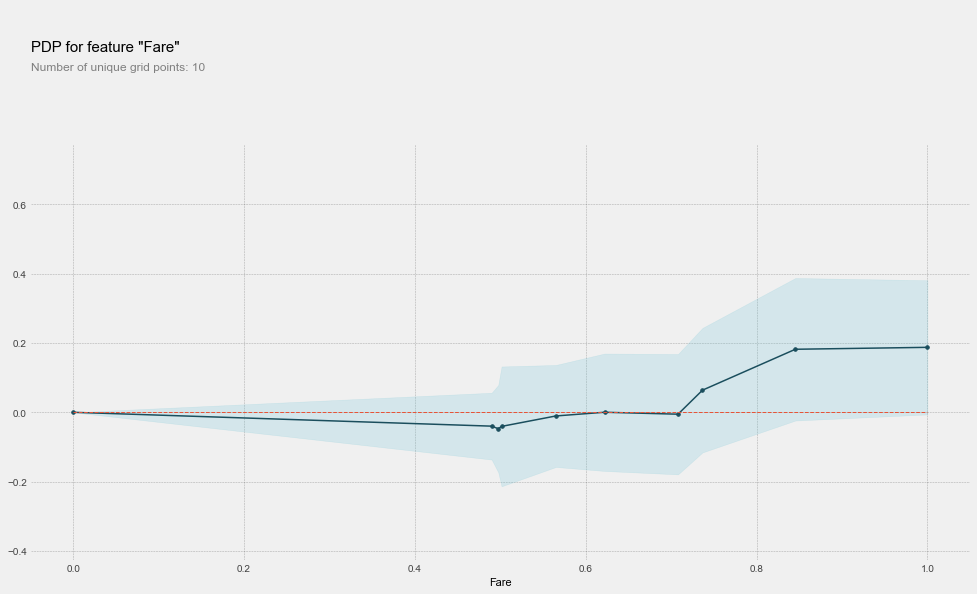

In [791]:
pdp_goals = pdp.pdp_isolate(model=clf, dataset=x_train,
                           model_features=features,
                           feature='Fare')
pdp.pdp_plot(pdp_goals, 'Fare')
plt.show()

#### Overall the higher the fares the higher the chance to survive except maybe for kids

### Summary plots

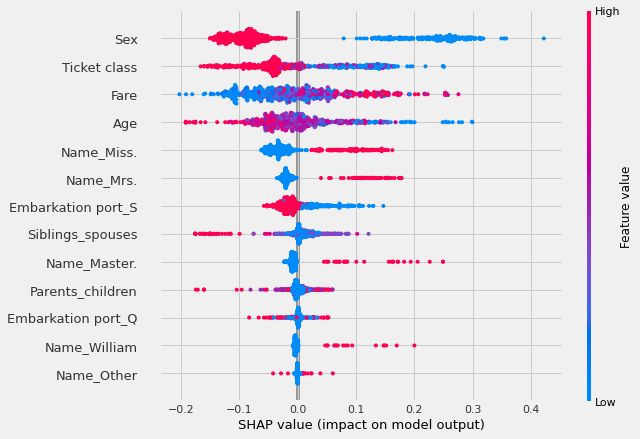

In [818]:
clf = RandomForestClassifier(**clf.best_params_)
clf.fit(x_train, y_train)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values[1], x_train)

## Simplify our model

In [793]:
cols = x.columns.tolist()
weights = perm.feature_importances_.tolist()
d = list(zip(cols, weights))
d = pd.DataFrame(d, columns=['Features', 'Weights']).sort_values(by='Weights', ascending=False)

In [794]:
imp_features = []
features_used = []
clfs = []
scores = []
for i in d['Features']:
    imp_features.append(i)
    x = train[imp_features]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    clf = tuning_param(x_train, y_train)
    score = clf.score(x_test, y_test)
    clfs.append(clf)
    features_used.append(len(imp_features))
    scores.append(score)

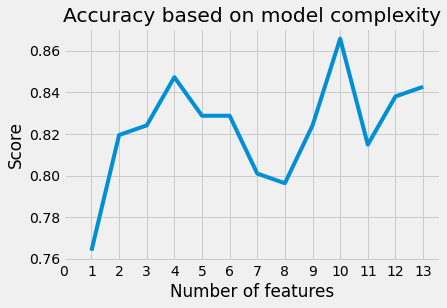

In [795]:
plt.plot(features_used, scores)
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.title('Accuracy based on model complexity')
plt.xticks([i for i in range(len(scores)+1)])
plt.show()

#### Maxmimum accuracy is with 10 features

In [ ]:
features = d['Features'][:(scores.index(max(scores))+1)].tolist()
x = train[features]
clf = clfs[scores.index(max(scores))]
feature

## Test data predictions


In [806]:
test_pred = pd.DataFrame(dataset_test['PassengerId'], columns=['PassengerId'])
test_pred['Survived'] = clf.predict(test[features])
test_pred['Survived'] = test_pred['Survived'].astype(int)
# Export data as csv
test_pred.to_csv("test_pred.csv", index=False)

## Conclusion

#### Most of the people who survived the titanic were either females or kids which is the rational decision to take if you were in charge , also the richier you are the highest your chance to survive